In [35]:
import os
#os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

os.environ['TF_USE_LEGACY_KERAS'] = '1';

In [36]:
input_default_json_conf_file='fcnn_emotion4_training_default.json';

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import json

In [38]:
import sys
sys.path.append('../library');

In [39]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [40]:
## Load json conf json file
fd = open(os.path.join('./',input_default_json_conf_file));
DATA = json.load(fd);
fd.close()

# Variable globales

In [41]:
## Seed for the random variables
seed_number=0;

## Dataset 
dataset_base_dir    = DATA['dataset_train_base_dir'];
dataset_labels_file = DATA['dataset_train_labels_file'];

dataset_base_dummy_dir    = DATA['dataset_dummy_base_dir'];
dataset_labels_dummy_file = DATA['dataset_dummy_labels_file'];

dataset_base_test_dir    = DATA['dataset_test_base_dir'];
dataset_labels_test_file = DATA['dataset_test_labels_file'];

dataset_name        = DATA['dataset_name'];

## Training hyperparameters
EPOCAS     = DATA["epochs"];
BATCH_SIZE = DATA["batch_size"];


## Output
output_base_dir = DATA["output_base_dir"];

patience=max(10,int(EPOCAS/5));
NCOD=15;
minus=None;
sub_dir='';


# Parametros de entrada

In [42]:
for n in range(len(sys.argv)):
    if sys.argv[n]=='--dataset-train-dir':
        dataset_base_dir=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-train-file':
        dataset_labels_file=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-dummy-dir':
        dataset_base_dummy_dir=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-dummy-file':
        dataset_labels_dummy_file=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-test-dir':
        dataset_base_test_dir=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-test-file':
        dataset_labels_test_file=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-name':
        dataset_name=sys.argv[n+1];
    elif sys.argv[n]=='--epochs':
        EPOCAS=int(sys.argv[n+1]);
    elif sys.argv[n]=='--batch-size':
        BATCH_SIZE=int(sys.argv[n+1]);
    elif sys.argv[n]=='--ncod':
        NCOD=int(sys.argv[n+1]);
    elif sys.argv[n]=='--patience':
        patience=int(sys.argv[n+1]);
    elif sys.argv[n]=='--seed':
        seed_number=int(sys.argv[n+1]);
    elif sys.argv[n]=='--sub-dir':
        sub_dir=sys.argv[n+1];
    elif sys.argv[n]=='--output-dir':
        output_base_dir=sys.argv[n+1];
    elif sys.argv[n]=='--minus':
        minus=int(sys.argv[n+1]);
        
if len(sub_dir)==0:
    if minus is None:
        sub_dir='cls_ncod'+str(NCOD);
    else:
        sub_dir='cls_minus'+str(minus)+'_ncod'+str(NCOD);

print('        dataset_base_dir:',dataset_base_dir)
print('     dataset_labels_file:',dataset_labels_file)
print('   dataset_base_test_dir:',dataset_base_dummy_dir)
print('dataset_labels_test_file:',dataset_labels_dummy_file)
print('   dataset_base_test_dir:',dataset_base_test_dir)
print('dataset_labels_test_file:',dataset_labels_test_file)
print('            dataset_name:',dataset_name)
print('                  EPOCAS:',EPOCAS)
print('              BATCH_SIZE:',BATCH_SIZE)
print('                    NCOD:',NCOD)
print('                patience:',patience)
print('             seed_number:',seed_number)
print('                 sub_dir:',sub_dir)
print('         output_base_dir:',output_base_dir)
print('                   minus:',minus)

        dataset_base_dir: /media/fernando/Expansion/DATASET/TESE/BER/BER2024/BER2024-FUSION/ber2024-source/ncod20_efficientnet_b3_efficientnet_b3_step1
     dataset_labels_file: train.csv
   dataset_base_test_dir: /media/fernando/Expansion/DATASET/TESE/BER/BER2024/BER2024-FUSION/dummy/L30000_p0.15
dataset_labels_test_file: train.csv
   dataset_base_test_dir: /media/fernando/Expansion/DATASET/TESE/BER/BER2024/BER2024-FUSION/ber2024-source/ncod20_efficientnet_b3_efficientnet_b3_step1
dataset_labels_test_file: test.csv
            dataset_name: ber2024-fusion
                  EPOCAS: 100
              BATCH_SIZE: 1024
                    NCOD: 15
                patience: 20
             seed_number: 0
         output_base_dir: /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4_fusion_1


# Set seed of random variables


In [43]:
np.random.seed(seed_number)
tf.keras.utils.set_random_seed(seed_number);

# Loading data of dataset

In [44]:
# Load filenames and labels
train_val_df = pd.read_csv(os.path.join(dataset_base_dir,dataset_labels_file));
#print(train_val_df)

# Setting labels
Y = train_val_df[['label']];
L=np.shape(Y)[0];

# Load dummy filenames and labels
dummy_df = pd.read_csv(os.path.join(dataset_base_dummy_dir,dataset_labels_dummy_file));

# Load test filenames and labels
test_df = pd.read_csv(os.path.join(dataset_base_test_dir,dataset_labels_test_file));

print('\n\ndummy_df')
print(dummy_df)

print('\n\ntest_df')
print(test_df)




dummy_df
             d0        d1        d2        d3        d4        d5        d6  \
0      0.224582  0.133591  0.225396  0.416430  0.115009  0.208645  0.231006   
1      0.037114  0.187126  0.258345  0.517415  0.115193  0.126007  0.259558   
2      0.007186  0.297487  0.224354  0.470973  0.206671  0.182703  0.151418   
3      0.367856  0.171388  0.282665  0.178091  0.521942  0.139584  0.279541   
4      0.276513  0.140360  0.482942  0.100184  0.113897  0.141131  0.465378   
...         ...       ...       ...       ...       ...       ...       ...   
29995  0.208061  0.537792  0.124906  0.129241  0.301961  0.505377  0.119539   
29996  0.275570  0.061500  0.047205  0.615725  0.127590  0.149018  0.243310   
29997  0.398522  0.134628  0.310514  0.156336  0.404484  0.191104  0.205217   
29998  0.023369  0.158488  0.776848  0.041295  0.240887  0.250146  0.278696   
29999  0.189666  0.127528  0.452404  0.230402  0.310355  0.173137  0.388660   

             d7        d8        d9     

# Setting the cross-validation split


In [45]:
from sklearn.model_selection import train_test_split

training_raw_df, validation_df = train_test_split(train_val_df, test_size=0.2,shuffle=True, stratify=Y)
if minus is None:
    training_df = pd.concat([training_raw_df, dummy_df], axis=0).reset_index(drop=True);
else:
    training_df = training_raw_df.copy();


print('\n\ntraining_df',training_df.shape)
print(training_df);


print('\n\nvalidation_df',validation_df.shape)
print(validation_df)



training_df
             d0        d1        d2        d3        d4            d5  \
17428  0.023349  0.975039  0.001465  0.000147  0.000480  9.995130e-01   
7726   0.004407  0.000271  0.993413  0.001908  0.072003  9.962386e-04   
12214  0.998762  0.000832  0.000368  0.000038  0.000788  4.939562e-03   
19469  0.000169  0.000054  0.997674  0.002102  0.000023  2.384938e-08   
13030  0.000195  0.000050  0.996027  0.003728  0.000011  3.453166e-07   
...         ...       ...       ...       ...       ...           ...   
29995  0.208061  0.537792  0.124906  0.129241  0.301961  5.053770e-01   
29996  0.275570  0.061500  0.047205  0.615725  0.127590  1.490182e-01   
29997  0.398522  0.134628  0.310514  0.156336  0.404484  1.911042e-01   
29998  0.023369  0.158488  0.776848  0.041295  0.240887  2.501460e-01   
29999  0.189666  0.127528  0.452404  0.230402  0.310355  1.731371e-01   

                 d6        d7        d8        d9       d10       d11  \
17428  4.485263e-10  0.000007  0.251

# Creating output directory

In [46]:
output_dir = os.path.join(output_base_dir,dataset_name,'training_validation_holdout',sub_dir);

os.makedirs(output_base_dir,exist_ok = True);

os.makedirs(output_dir,exist_ok = True);

# Data augmentation configuration

In [47]:

training_data_array   = training_df.iloc[:,:-1].values;
training_y_label = training_df.iloc[:,-1].values;

validation_data_array = validation_df.iloc[:,:-1].values;
validation_y_label = validation_df.iloc[:,-1].values;

test_data_array = test_df.iloc[:,:-1].values;
test_y_label = test_df.iloc[:,-1].values;

print('train:',training_data_array.shape, training_y_label.shape)
print('  val:',validation_data_array.shape, validation_y_label.shape)
print(' test:',test_data_array.shape, test_y_label.shape)

train: (51567, 12) (51567,)
  val: (5392, 12) (5392,)
 test: (16658, 12) (16658,)


In [48]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()

training_y   = label_encoder.fit_transform(training_y_label)
validation_y = label_encoder.fit_transform(validation_y_label)
test_y       = label_encoder.fit_transform(test_y_label)

training_y_categorical   = to_categorical(training_y)
validation_y_categorical = to_categorical(validation_y)
test_y_categorical       = to_categorical(test_y)


print('train:',training_data_array.shape,training_y_categorical.shape)
print('  val:',validation_data_array.shape,validation_y_categorical.shape)
print(' test:',test_data_array.shape,test_y_categorical.shape)


train: (51567, 12) (51567, 4)
  val: (5392, 12) (5392, 4)
 test: (16658, 12) (16658, 4)


# Create new model

In [49]:
import FusionEmotion4Lib.lib_model as mpp

model = mpp.create_model(  load_weights=False,
                           file_of_weight='',
                           ncod=NCOD,
                           minus=minus);

print('input_shape',model.input_shape)
print('output_shape',model.output_shape)
print('')

model.summary()

mpp.save_model_parameters(model, os.path.join(output_dir,'parameters_stats.m'));

input_shape (None, 12)
output_shape (None, 4)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                195       
                                                                 
 dense_1 (Dense)             (None, 4)                 64        
                                                                 
Total params: 259 (1.01 KB)
Trainable params: 259 (1.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-08-09 00:35:40.458887: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 00:35:40.459250: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 00:35:40.459494: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [50]:
# COMPILE NEW MODEL
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

# CREATE CALLBACKS
best_model_file=os.path.join(output_dir,'model_ncod'+str(NCOD)+'.h5');
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_file, 
                                                save_weights_only=True,
                                                monitor='val_loss', 
                                                save_best_only=True, 
                                                verbose=1);

# Definindo o callback EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(  monitor='val_loss', 
                                                    patience=patience,  
                                                    verbose=1, 
                                                    restore_best_weights=False);

log_dir = os.path.join(output_dir,"logs","fit",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"));
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [51]:
# FIT THE MODEL
history = model.fit(training_data_array,training_y_categorical,
                    epochs=EPOCAS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_data_array,validation_y_categorical),
                    callbacks=[checkpoint,early_stopping,tensorboard_callback],
                    verbose=1
                   );

Epoch 1/100


I0000 00:00:1723174557.827165   12076 service.cc:145] XLA service 0x7180489546b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723174557.827239   12076 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce MX150, Compute Capability 6.1
2024-08-09 00:35:57.847490: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-09 00:35:57.908281: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1723174558.023095   12076 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/51 [===========================>..] - ETA: 0s - loss: 1.3389 - categorical_accuracy: 0.3155
Epoch 1: val_loss improved from inf to 1.12180, saving model to /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4_fusion_1/ber2024-fusion/training_validation_holdout/cls_ncod15/model_ncod15.h5
51/51 [==============================] - 17s 20ms/step - loss: 1.3332 - categorical_accuracy: 0.3249 - val_loss: 1.1218 - val_categorical_accuracy: 0.7040
Epoch 2/100
51/51 [==============================] - ETA: 0s - loss: 1.0948 - categorical_accuracy: 0.7173
Epoch 2: val_loss improved from 1.12180 to 0.77453, saving model to /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4_fusion_1/ber2024-fusion/training_validation_holdout/cls_ncod15/model_ncod15.h5
51/51 [==============================] - 0s 9ms/step - loss: 1.0948 - categorical_accuracy: 0.7173 - val_loss: 0.7745 - val_categorical_accuracy: 0.9494
Epoch 3/100
49/51 [===========================>..] - ETA: 0s - loss: 0.8568 - cate

max_val_acc 0.9781157374382019


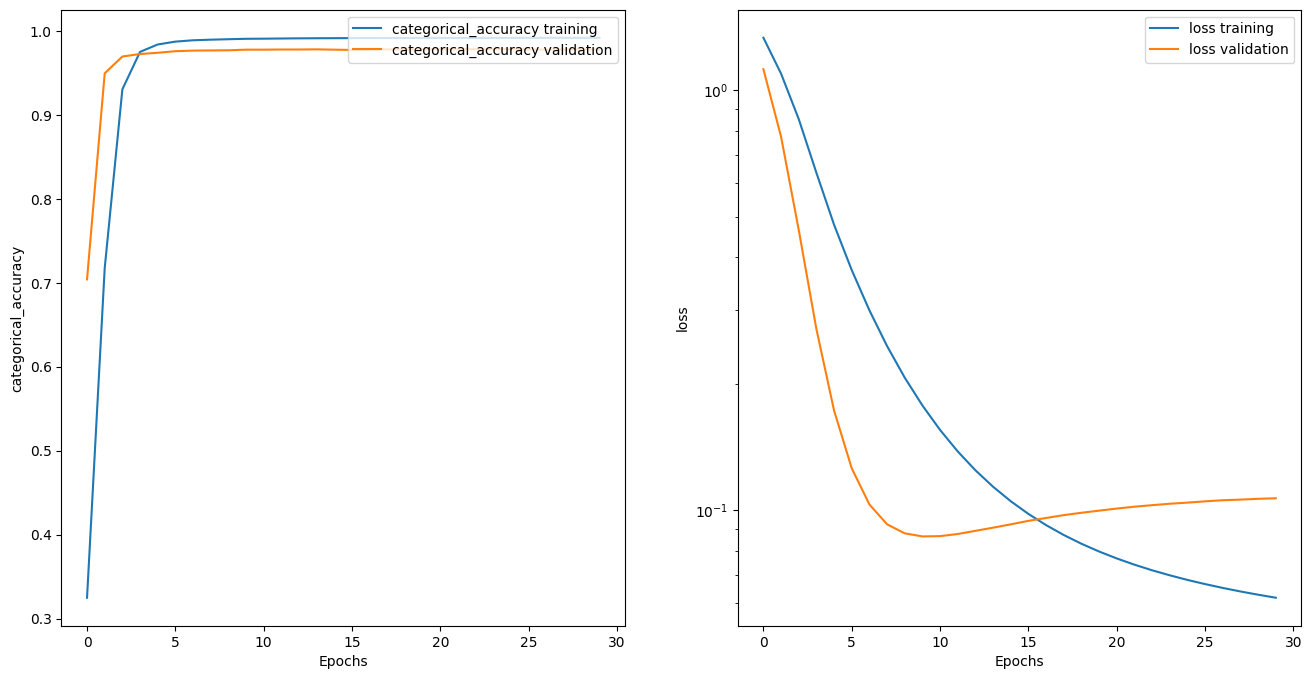

In [52]:
mpp.save_model_history(history,
                       os.path.join(output_dir,"historical.csv"),
                       show=False,
                       labels=['categorical_accuracy','loss']);

In [53]:
# LOAD BEST MODEL to evaluate the performance of the model
model.load_weights(best_model_file);
data_results=dict();

# Evaluate training
results = model.evaluate(training_data_array,training_y_categorical)
results = dict(zip(model.metrics_names,results))
print('training',results,"\n\n");
for key,value in results.items():
    data_results['train_'+key]=value;

# Evaluate validation
results = model.evaluate(validation_data_array,validation_y_categorical)
results = dict(zip(model.metrics_names,results))
print('validation',results,"\n\n");
for key,value in results.items():
    data_results['val_'+key]=value;

# Evaluate testing
results = model.evaluate(test_data_array,test_y_categorical)
results = dict(zip(model.metrics_names,results))
print('testing',results,"\n\n");
for key,value in results.items():
    data_results['test_'+key]=value;

data_results['number_of_parameters']=mpp.get_model_parameters(model);
data_results['ncod']=NCOD;
data_results['epochs']=EPOCAS;
data_results['patience']=patience;
data_results['seed']=seed_number;

# final all json
with open(os.path.join(output_dir,"training_data_results.json"), 'w') as f:
    json.dump(data_results, f,indent=4);

tf.keras.backend.clear_session()

1612/1612 [==============================] - 4s 2ms/step - loss: 0.1649 - categorical_accuracy: 0.9905
training {'loss': 0.1648501455783844, 'categorical_accuracy': 0.9904783964157104} 


169/169 [==============================] - 0s 2ms/step - loss: 0.0865 - categorical_accuracy: 0.9776
validation {'loss': 0.08647266030311584, 'categorical_accuracy': 0.9775593280792236} 


521/521 [==============================] - 2s 3ms/step - loss: 0.1264 - categorical_accuracy: 0.9685
testing {'loss': 0.12638325989246368, 'categorical_accuracy': 0.9684836268424988} 




521/521 [==============================] - 1s 2ms/step
Categorical accuracy: 0.9684836114779686
{
    "negative": {
        "precision": 0.9463150459147633,
        "recall": 0.9553125742809603,
        "f1-score": 0.9507925242488763,
        "support": 4207.0
    },
    "neutral": {
        "precision": 0.9622988505747126,
        "recall": 0.9410971223021583,
        "f1-score": 0.9515799045237554,
        "support": 4448.0
    },
    "pain": {
        "precision": 0.9753054989816701,
        "recall": 0.9917162826818535,
        "f1-score": 0.9834424335772045,
        "support": 3863.0
    },
    "positive": {
        "precision": 0.9912896201306557,
        "recall": 0.9896135265700483,
        "f1-score": 0.9904508642572223,
        "support": 4140.0
    },
    "accuracy": 0.9684836114779686,
    "macro avg": {
        "precision": 0.9688022539004505,
        "recall": 0.969434876458755,
        "f1-score": 0.9690664316517646,
        "support": 16658.0
    },
    "weighted avg": 

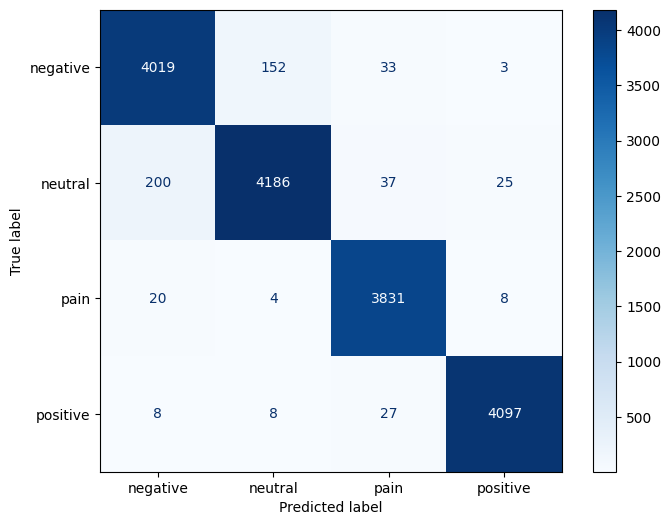

In [54]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

target_names = ['negative','neutral','pain','positive'];

# Predict
Y_pred = model.predict(test_data_array,verbose=1);
y_pred = np.argmax(Y_pred, axis=1);

# Calculate accuracy
categorical_accuracy = np.mean(test_y == y_pred);
print(f'Categorical accuracy: {categorical_accuracy}');

# Confusion matrix
CM=confusion_matrix(test_y, y_pred);

fname=os.path.join(output_dir,"confusion_matrix.eps");
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=target_names)
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.savefig(fname)

cm_dict=dict();
cm_dict['matrix']=CM.tolist();
cm_dict['label']=target_names;
# final all json
with open(os.path.join(output_dir,"confusion_matrix.json"), 'w') as f:
    json.dump(cm_dict, f,indent=4);
    f.close()

# Classification report
fname=os.path.join(output_dir,"classification_report.json")
dict_dat=classification_report(test_y, y_pred, target_names=target_names,output_dict=True);
print(json.dumps(dict_dat, indent=4))
with open(fname, 'w') as f: 
    json.dump(dict_dat, f,indent=4);
    f.close()